# Find Label Errors in Multi-Label Classification Datasets

This 5-minute quickstart tutorial demonstrates how to find potential label errors in multi-label classification datasets. In such datasets, each example is labeled as belonging to one *or more* classes (unlike in *multi-class classification* where each example can only belong to one class). For a particular example in such multi-label classification data, we say each class either applies or not. We may even have some examples where *no* classes apply. Common applications of this include image tagging (or document tagging), where multiple tags can be appropriate for a single image (or document). For example, a image tagging application could involve the following classes: [`copyrighted`, `advertisement`, `face`, `violence`, `nsfw`]

<div class="alert alert-info">
Quickstart
<br/>
    
cleanlab finds label issues based on two inputs: `labels` formatted as a list of lists of integer class indices that apply to each example in your dataset, and `pred_probs` from a trained multi-label classification model (which do not need to sum to 1 since the classes are not mutually exclusive). Once you have these, run the code below to find label issues in your dataset.

<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```ipython3 
from cleanlab.filter import find_label_issues

ranked_label_issues = find_label_issues(
    labels=labels,
    pred_probs=pred_probs,
    multi_label=True,
    return_indices_ranked_by="self_confidence",
)
```

    
</div>
</div>

## 1. Install required dependencies and get dataset

You can use `pip` to install all packages required for this tutorial as follows:

```ipython3
!pip install cleanlab matplotlib
# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git

```

In [1]:
# Package installation (hidden on docs.cleanlab.ai).
# Package versions we used: matplotlib==3.5.1

dependencies = ["cleanlab", "matplotlib"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

In [2]:
import random
import numpy as np
import sklearn
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

from cleanlab.filter import find_label_issues
import cleanlab.internal.multilabel_utils as mlutils
from cleanlab.internal.multilabel_utils import onehot2int, int2onehot
from cleanlab.benchmarking.noise_generation import (
    generate_noise_matrix_from_trace,
    generate_noisy_labels,
)

Here we generate a small multi-label classification dataset for a quick demo. To see cleanlab applied to a real image tagging dataset, check out our [example](https://github.com/cleanlab/examples) notebook ["Find Label Errors in Multi-Label Classification Data (CelebA Image Tagging)"](https://github.com/cleanlab/examples/blob/master/multilabel_classification/image_tagging.ipynb).

<details><summary>Code to generate dataset (can skip these details) **(click to expand)**</summary>
    
```ipython3
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.
    
m = 3 #num_classes
def make_multilabel_data(
    means=[[-5, 2], [0, 2], [-3, 6]],
    covs=[[[3, -1.5], [-1.5, 1]], [[5, -1.5], [-1.5, 1]], [[3, -1.5], [-1.5, 1]]],
    boxes_coordinates=[[-3.5, 0, -1.5, 1.7], [-1, 3, 2, 4], [-5, 2, -3, 4], [-3, 2, -1, 4]],
    box_multilabels=[[0, 1], [1, 2], [0, 2], [0, 1, 2]],
    sizes=[100, 80, 100],
    avg_trace=0.9,
    seed=1,
):
    np.random.seed(seed=seed)
    num_classes = len(means)
    m = num_classes + len(
        box_multilabels
    )  # number of classes by treating each multilabel as 1 unique label
    n = sum(sizes)
    local_data = []
    labels = []
    test_data = []
    test_labels = []
    for i in range(0, len(means)):
        local_data.append(np.random.multivariate_normal(mean=means[i], cov=covs[i], size=sizes[i]))
        test_data.append(np.random.multivariate_normal(mean=means[i], cov=covs[i], size=sizes[i]))
        test_labels += [[i]] * sizes[i]
        labels += [[i]] * sizes[i]

    def make_multi(X, Y, bx1, by1, bx2, by2, label_list):
        ll = np.array([bx1, by1])  # lower-left
        ur = np.array([bx2, by2])  # upper-right

        inidx = np.all(np.logical_and(X.tolist() >= ll, X.tolist() <= ur), axis=1)
        for i in range(0, len(Y)):
            if inidx[i]:
                Y[i] = label_list
        return Y

    X_train = np.vstack(local_data)
    X_test = np.vstack(test_data)

    for i in range(0, len(box_multilabels)):
        bx1, by1, bx2, by2 = boxes_coordinates[i]
        multi_label = box_multilabels[i]
        labels = make_multi(X_train, labels, bx1, by1, bx2, by2, multi_label)
        test_labels = make_multi(X_test, test_labels, bx1, by1, bx2, by2, multi_label)

    d = {}
    for i in labels:
        if str(i) not in d:
            d[str(i)] = len(d)
    inv_d = {v: k for k, v in d.items()}
    labels_idx = [d[str(i)] for i in labels]
    py = np.bincount(labels_idx) / float(len(labels_idx))
    noise_matrix = generate_noise_matrix_from_trace(
        m,
        trace=avg_trace * m,
        py=py,
        valid_noise_matrix=True,
        seed=seed,
    )
    noisy_labels_idx = generate_noisy_labels(labels_idx, noise_matrix)
    noisy_labels = [eval(inv_d[i]) for i in noisy_labels_idx]
    return {
        "X_train": X_train,
        "true_labels_train": labels,
        "X_test": X_test,
        "true_labels_test": test_labels,
        "labels": noisy_labels,
        "dict_unique_label": d,
        'labels_idx': noisy_labels_idx,

    }

def get_color_array(labels):
    """
    This function returns a dictionary mapping multi-labels to unique colors
    """
    dcolors ={'[0]': 'aa4400',
             '[0, 2]': '55227f',
             '[0, 1]': '55a100',
             '[1]': '00ff00',
             '[1, 2]': '007f7f',
             '[0, 1, 2]': '386b55',
             '[2]': '0000ff'}

    return ["#"+dcolors[str(i)] for i in labels]

def plot_data(data, circles, title, alpha=1.0,colors = []):
    plt.figure(figsize=(14, 5))
    done = set()
    for i in range(0,len(data)):
        lab = str(labels[i])
        if lab in done:
            label = ""
        else:
            label = lab
            done.add(lab)
        plt.scatter(data[i, 0], data[i, 1], c=colors[i], s=30,alpha=0.6, label = label)
    for i in circles:
        plt.plot(
            data[i][0],
            data[i][1],
            "o",
            markerfacecolor="none",
            markeredgecolor="red",
            markersize=14,
            markeredgewidth=2.5,
            alpha=alpha
        )
    _ = plt.title(title, fontsize=25)
    plt.legend()
```
    
</details>

In [3]:
def make_multilabel_data(
    means=[[-5, 2], [0, 2], [-3, 6]],
    covs=[[[3, -1.5], [-1.5, 1]], [[5, -1.5], [-1.5, 1]], [[3, -1.5], [-1.5, 1]]],
    boxes_coordinates=[[-3.5, 0, -1.5, 1.7], [-1, 3, 2, 4], [-5, 2, -3, 4], [-3, 2, -1, 4]],
    box_multilabels=[[0, 1], [1, 2], [0, 2], [0, 1, 2]],
    sizes=[100, 80, 100],
    avg_trace=0.9,
    seed=1,
):
    np.random.seed(seed=seed)
    num_classes = len(means)
    m = num_classes + len(
        box_multilabels
    )  # number of classes by treating each multilabel as 1 unique label
    n = sum(sizes)
    local_data = []
    labels = []
    test_data = []
    test_labels = []
    for i in range(0, len(means)):
        local_data.append(np.random.multivariate_normal(mean=means[i], cov=covs[i], size=sizes[i]))
        test_data.append(np.random.multivariate_normal(mean=means[i], cov=covs[i], size=sizes[i]))
        test_labels += [[i]] * sizes[i]
        labels += [[i]] * sizes[i]

    def make_multi(X, Y, bx1, by1, bx2, by2, label_list):
        ll = np.array([bx1, by1])  # lower-left
        ur = np.array([bx2, by2])  # upper-right

        inidx = np.all(np.logical_and(X.tolist() >= ll, X.tolist() <= ur), axis=1)
        for i in range(0, len(Y)):
            if inidx[i]:
                Y[i] = label_list
        return Y

    X_train = np.vstack(local_data)
    X_test = np.vstack(test_data)

    for i in range(0, len(box_multilabels)):
        bx1, by1, bx2, by2 = boxes_coordinates[i]
        multi_label = box_multilabels[i]
        labels = make_multi(X_train, labels, bx1, by1, bx2, by2, multi_label)
        test_labels = make_multi(X_test, test_labels, bx1, by1, bx2, by2, multi_label)

    d = {}
    for i in labels:
        if str(i) not in d:
            d[str(i)] = len(d)
    inv_d = {v: k for k, v in d.items()}
    labels_idx = [d[str(i)] for i in labels]
    py = np.bincount(labels_idx) / float(len(labels_idx))
    noise_matrix = generate_noise_matrix_from_trace(
        m,
        trace=avg_trace * m,
        py=py,
        valid_noise_matrix=True,
        seed=seed,
    )
    noisy_labels_idx = generate_noisy_labels(labels_idx, noise_matrix)
    noisy_labels = [eval(inv_d[i]) for i in noisy_labels_idx]
    return {
        "X_train": X_train,
        "true_labels_train": labels,
        "X_test": X_test,
        "true_labels_test": test_labels,
        "labels": noisy_labels,
        "dict_unique_label": d,
        'labels_idx': noisy_labels_idx,

    }

def get_color_array(labels):
    """
    This function returns a dictionary mapping multi-labels to unique colors
    """
    dcolors ={'[0]': 'aa4400',
             '[0, 2]': '55227f',
             '[0, 1]': '55a100',
             '[1]': '00ff00',
             '[1, 2]': '007f7f',
             '[0, 1, 2]': '386b55',
             '[2]': '0000ff'}

    return ["#"+dcolors[str(i)] for i in labels]

def plot_data(data, circles, title, alpha=1.0,colors = []):
    plt.figure(figsize=(14, 5))
    done = set()
    for i in range(0,len(data)):
        lab = str(labels[i])
        if lab in done:
            label = ""
        else:
            label = lab
            done.add(lab)
        plt.scatter(data[i, 0], data[i, 1], c=colors[i], s=30,alpha=0.6, label = label)
    for i in circles:
        plt.plot(
            data[i][0],
            data[i][1],
            "o",
            markerfacecolor="none",
            markeredgecolor="red",
            markersize=14,
            markeredgewidth=2.5,
            alpha=alpha
        )
    _ = plt.title(title, fontsize=25)
    plt.legend()

Some of the labels in our generated dataset purposely contain errors. The examples with label errors are circled in the plot below, which depicts the dataset. This dataset contains 3 classes, and any subset of these may be the given label for a particular example. We say this example has a label error if it is better described by an alternative  subset of the classes than the given label.

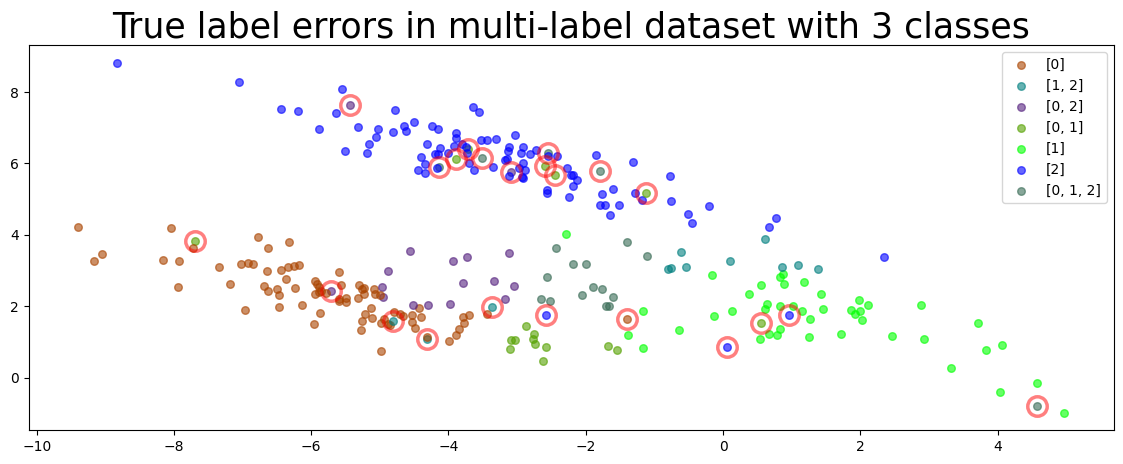

In [4]:
num_class = 3
dataset = make_multilabel_data()
labels = dataset['labels']
true_errors = np.where(np.sum(int2onehot(dataset['true_labels_train'],3)!=int2onehot(dataset['labels'],3),axis=1)>=1)[0]
plot_data(dataset['X_train'], circles=true_errors, title=f"True label errors in multi-label dataset with {num_class} classes", colors = get_color_array(labels),alpha=0.5)

## 2. Format data, labels, and model predictions

In multi-label classification, each example in the dataset is labeled as belonging to one **or more** of *K* possible classes. To find label issues, cleanlab requires predicted class probabilities from a trained classifier. 
Here we produce out-of-sample `pred_probs` by employing cross-validation to fit a multi-label **RandomForestClassifier** model via sklearn's [`OneVsRestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) framework. `OneVsRestClassifier` offers an easy way to apply any multi-class classifier model from sklearn to multi-label classification tasks.

To train a state-of-the-art Pytorch neural network for multi-label classification and produce `pred_probs` on a real image dataset, see our [example](https://github.com/cleanlab/examples) notebook ["Train a neural network for multi-label classification on the CelebA dataset"](https://github.com/cleanlab/examples/blob/master/multilabel_classification/pytorch_network_training.ipynb). 

In [5]:
SEED =0
y_onehot = int2onehot(labels, K=num_class)  # labels in a binary format for sklearn OneVsRestClassifier
single_class_labels = [random.choice(i) for i in labels]  # used only for stratifying the cross-validation split 
clf = OneVsRestClassifier(RandomForestClassifier(random_state=SEED))
pred_probs = np.zeros(shape=(len(labels), num_class))
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for train_index, test_index in kf.split(X=dataset['X_train'], y=single_class_labels):
    clf_cv = sklearn.base.clone(clf)
    X_train_cv, X_test_cv = dataset['X_train'][train_index], dataset['X_train'][test_index]
    y_train_cv, y_test_cv = y_onehot[train_index], y_onehot[test_index]
    clf_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = clf_cv.predict_proba(X_test_cv)
    pred_probs[test_index] = y_pred_cv

`pred_probs` should be 2D array whose rows are length-*K* vectors for **each** example in the dataset, representing the model-estimated probability that this example belongs to each class. Since one example can belong to multiple classes in multi-label classification, these probabilities need not sum to 1. For the best label error detection performance, these `pred_probs` should be out-of-sample (from a copy of the model that never saw this example during training, e.g. produced via cross-validation).

`labels` should be a list of lists, whose *i*-th entry is a list of (integer) class indices that apply to the *i*-th example in the dataset. If your classes are represented as string names, you should map these to integer indices. The label for an example that belongs to none of the classes should just be an empty list `[]`.

Once you have `pred_probs` and `labels` in the appropriate formats, you can find label issues with cleanlab for any multi-label dataset!

Here's what these look like for the first few examples in our synthetic multi-label dataset: 

In [6]:
num_to_display = 3  # increase this to see more examples

print(f"labels for first {num_to_display} examples in cleanlab format:")
print(labels[:num_to_display])
print(f"pred_probs for first {num_to_display} examples in cleanlab format:")
print(pred_probs[:num_to_display])

labels for first 3 examples in cleanlab format:
[[0], [1, 2], [0]]
pred_probs for first 3 examples in cleanlab format:
[[1.   0.02 0.01]
 [1.   0.28 0.02]
 [0.97 0.   0.01]]


## 3. Use cleanlab to find label issues 

Based on the given `labels` and `pred_probs` from a trained model, cleanlab can quickly help us find label errors in our dataset. Here we request that the indices of the examples identified with label issues be sorted by cleanlab’s normalized margin score, which is used to measure the quality of individual labels. The returned `issues` are a list of indices corresponding to the examples in your dataset that cleanlab finds most likely to be mislabeled. These indices are sorted by the *self-confidence* label quality score, with the lowest quality labels at the start.


In [7]:
issues = find_label_issues(
    labels=labels,
    pred_probs=pred_probs,
    multi_label=True,
    return_indices_ranked_by="self_confidence",
)

print(f"Indices of examples with label issues:\n{issues}")

2022-11-14 15:31:53.608472: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.8.14/x64/lib
2022-11-14 15:31:53.608513: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Indices of examples with label issues:
[216 276  65   1 229  21 172 175 278 188 176 251 143 214 184 102 140 253
  19 266 240  47 167 234  44 120   9 194 107  14]


Note we specified the `multi_label` option above to distinguish the task from *multi-class classification* (otherwise assumed as the default task).

Let's look at the samples that cleanlab thinks are most likely to be mislabeled. You can see that cleanlab was able to identify most of `true_errors` in our small dataset (despite not having access to this variable, which you won't have in your own applications).

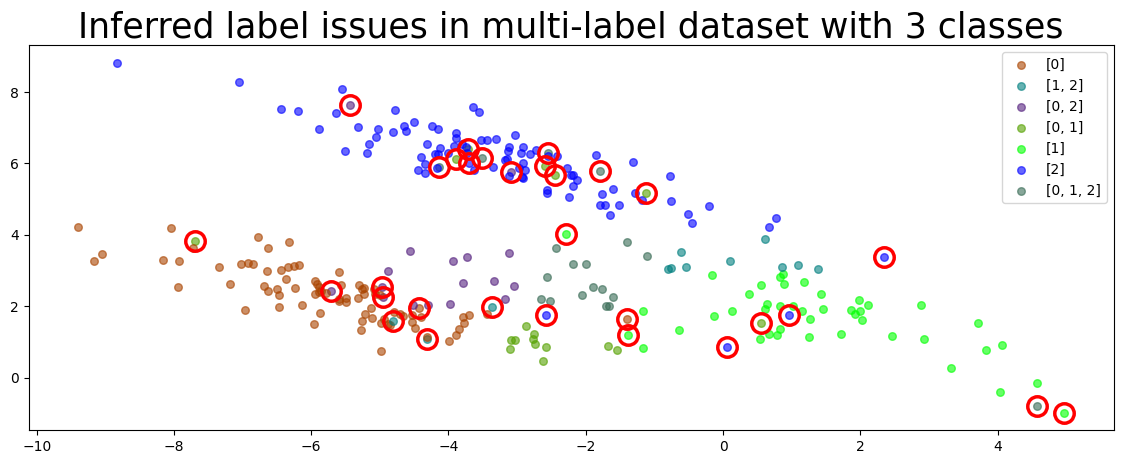

In [8]:
plot_data(dataset['X_train'], circles=issues, title=f"Inferred label issues in multi-label dataset with {num_class} classes", colors = get_color_array(labels), alpha = 1)

### How to format labels given as a one-hot (multi-hot) binary matrix?

For multi-label classification, cleanlab expects labels to be formatted as a list of lists, where each entry is an integer corresponding to a particular class. Here are some functions you can use to easily convert labels between this format and a binary matrix format commonly used to train multi-label classification models.

In [9]:
from cleanlab.internal.multilabel_utils import int2onehot, onehot2int

labels_binary_format = int2onehot(labels, K=num_class)
labels_list_format = onehot2int(labels_binary_format)

To see cleanlab applied to a real image tagging dataset, check out our [example](https://github.com/cleanlab/examples) notebook ["Find Label Errors in Multi-Label Classification Data (CelebA Image Tagging)"](https://github.com/cleanlab/examples/blob/master/multilabel_classification/image_tagging.ipynb). That example also demonstrates how to use a state-of-the-art Pytorch neural network for multi-label classification with image data.

In [10]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

A = set(issues)
B = set(true_errors)
jaccard = len(A.intersection(B)) / len(A.union(B))
if not jaccard > 0.65:
    raise Exception("issues does not overlap much with the true errors")